# cellular image classification for malaria dataset

TensorFlow Datasets has many datasets that can be loaded and be used to learn more about image classification and various computer vision machine learning pipelines. It is a great way to learn more about TensorFlow and the architecture of computer vision models in general. This tutorial will go over the importance of data exploration as well as all the steps for a image classification machine learning problem.

In [116]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc
import cv2

# Initial Exploration

We will be using the TFDS Malaria dataset. The Malaria dataset is contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. The original data source is from [NIH](https://lhncbc.nlm.nih.gov/publication/pub9932). A big aspect of machine learning is data processing. Feature engineering and normalizing data is important. Correctly formatted data will help the model train better and make better inferences about the data.

## Loading the data

We'll be using TFDS Malaria dataset for our example. It is quite easy to load the data using TFDS API.

In [117]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

In [118]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


As expected, we have two different classes of images: a "parasitized" class and an "uninfected" class.

## Visualize the data

Let's use the TFDS API to visualize how our images look like.

## Feature extraction

Let's convert our images and labels into numpy arrars for our initial analysis.

In [119]:
train_images = []
train_labels = []
infacted_index = 0
uninfacted_index = 0

for idx,example in enumerate(ds):
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())
    if example['label'].numpy() == 0 and infacted_index ==0:
        infacted_index =idx
    if example['label'].numpy() == 1 and uninfacted_index ==0:
        uninfacted_index =idx
        
        
    

In [120]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

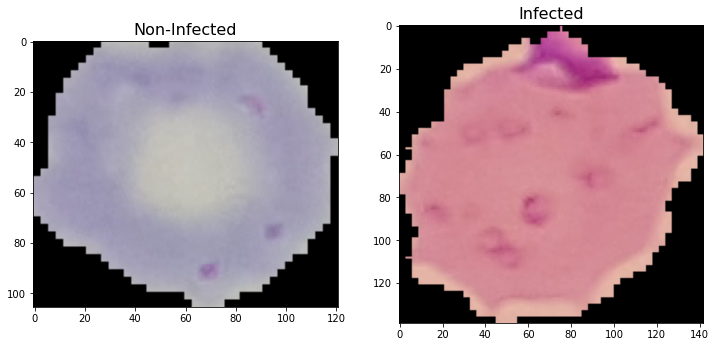

Shape Infected: (139, 142, 3) 
Shape Non-Infected: (106, 121, 3)


In [121]:
image_infected = train_images[infacted_index]
image_noninfected = train_images[uninfacted_index]

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.imshow(image_noninfected)
ax1.set_title("Non-Infected", size=16)

ax2.imshow(image_infected)
ax2.set_title("Infected", size=16)
plt.show()

print(f"Shape Infected: {image_infected.shape} \nShape Non-Infected: {image_noninfected.shape}")

In [122]:
print("Image:")
print(train_images[1])
print("Label: " + str(train_labels[1]))

Image:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Label: 0


As we see in our visualizations, not all of the images are of the same size. Additionally, our images, and for most computer vision problems, images will be a 3-channel matrix, meaning 3 matrices are stacked on top of each, one for each color of RGB. Sometimes, features of our image like size, length, and shape can be strong correlations with our labels.

Let's evaluate the length of our images.

In [123]:
images_flattened = [x.flatten().astype('float64') for x in train_images]

In [124]:
img_lengths = []

for img in images_flattened:
    img_lengths.append(len(img))

In [125]:
img_lengths = np.array(img_lengths)

Let's see our the lengths of the images identified as "uninfected" differ from the lengths of the images identifies as "parasitized".

In [126]:
uninfected_lengths = img_lengths[train_labels]
parasitized_lengths = img_lengths[train_labels == 0]

In [127]:
scipy.stats.describe(uninfected_lengths)

DescribeResult(nobs=27558, minmax=(31827, 59214), mean=45520.5, variance=187518746.76218385, skewness=0.0, kurtosis=-1.9999999999999998)

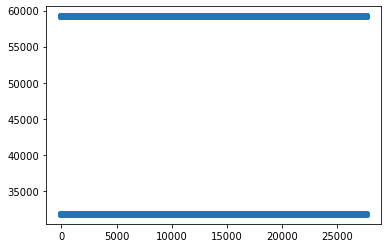

In [128]:
plt.scatter(np.arange(len(uninfected_lengths)), uninfected_lengths)

In [129]:
np.unique(uninfected_lengths)

array([31827, 59214])

We see that for the uninfected images, the length of the flattened image array is either 41745 or 54165. Now let's see the lengths of the parasitized images.

In [130]:
scipy.stats.describe(parasitized_lengths)

DescribeResult(nobs=13779, minmax=(6600, 371280), mean=54644.67798824298, variance=271685467.83177775, skewness=2.7492421162518896, kurtosis=26.06788500133635)

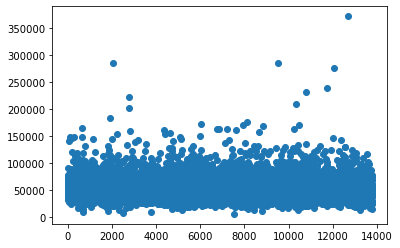

In [131]:
plt.scatter(np.arange(len(parasitized_lengths)), parasitized_lengths)

In [132]:
np.unique(parasitized_lengths)

array([  6600,   9048,   9660,  10902,  11136,  11163,  13224,  14016,
        14070,  14592,  15330,  15879,  15960,  16590,  16644,  17202,
        17220,  17301,  17850,  18012,  18615,  18696,  18723,  19110,
        19272,  19380,  19434,  19497,  20064,  20145,  20172,  20586,
        20748,  20856,  20910,  21243,  21567,  21648,  21675,  21900,
        22116,  22143,  22386,  22440,  22800,  22989,  23124,  23205,
        23214,  23232,  23700,  23862,  23871,  23970,  24024,  24411,
        24600,  24735,  24816,  24843,  24852,  25122,  25500,  25608,
        25662,  25833,  26076,  26220,  26265,  26400,  26481,  26508,
        26814,  27030,  27156,  27192,  27255,  27300,  27336,  27354,
        27795,  27966,  27984,  28119,  28200,  28227,  28272,  28290,
        28560,  28776,  28938,  29028,  29046,  29100,  29325,  29568,
        29757,  29766,  29892,  29973,  30000,  30090,  30360,  30504,
        30576,  30738,  30846,  30855,  30900,  31152,  31395,  31584,
      

For the parasitized lengths, we see that images are a wide variety of lengths. For certain models, having a feature that corresponds with the label can be an issue as the model might assume that the length of an image corresponds with its classification. This will make it difficult to generalize the model as not all uninfected blood smear images are of the same size. To help prevent overfitting and to generalize our model, we will preprocess our images before inputing them.

But first, let's clear some RAM so we don't run out of resources.

In [133]:
del ds
del info
del train_images
del train_labels
del images_flattened
del img_lengths

gc.collect()

27519

## Loading images

We first want to load our images into three different datasets: a training dataset, a validation dataset, and a training dataset.

In [134]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:5%]', 'train[10%:12%]', 'train[95%:]'],
                                      shuffle_files=True, as_supervised=True)

We will divide our data into 70:15:15 ratio. We can check that our ratios are correct by checking how many images are in each dataset.

In [135]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: -2
Num validating images: -2
Num testing images: -2


## Reshape image input

Let's see the shapes of our images.

In [136]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


Not all the images are of size (200, 200). Thankfully, TensorFlow Image API has a way to resize images by either cropping big pictures or padding smaller ones. Let's define our padding method.

In [137]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def pad(image,label):
    image,label = convert(image, label)
    image = tf.image.resize_with_crop_or_pad(image, 200, 200)
    return image,label

We have to use `.map()` to apply our padding method to all of our images. While we are at it, we should batch our images.

In [138]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

## Visualize padded images

In [139]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

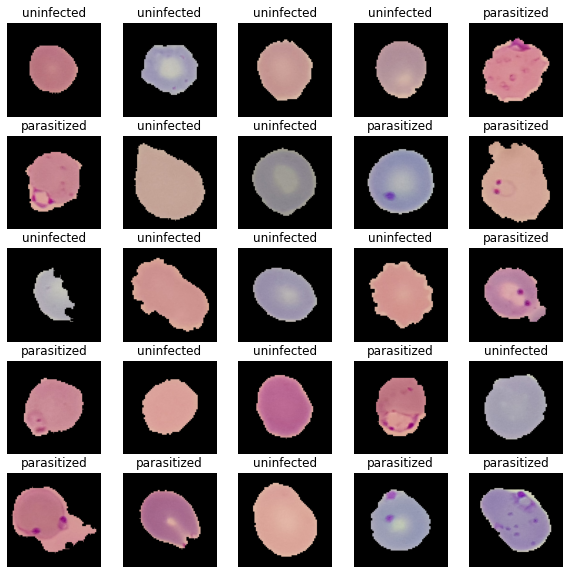

In [140]:
show_batch(image_batch.numpy(), label_batch.numpy())